In [76]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from joblib import Parallel, delayed
import math
import os
import ast
import gc
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from pathlib import Path
from sklearn.preprocessing import RobustScaler
from typing import Tuple, List

gt1 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (1).csv')
gt2 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (2).csv')
gt3 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (3).csv')
gt4 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (4).csv')

gt = pd.concat([gt1, gt2, gt3, gt4]).drop_duplicates().reset_index(drop=True)

def append_df(df: pd.DataFrame, path: str):
    header = not os.path.exists(path)
    df.to_csv(path, mode="a", index=False, header=header)



NUMERIC_COLS = [
    "unique_location_ids",
    "avg_distance_from_home_km",
    "avg_speed_kmh",
    "max_stay_duration",
    "transformations",
    "max_distance_from_home",
]

def scale_train_test(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    numeric_cols: List[str] = NUMERIC_COLS,
) -> Tuple[pd.DataFrame, pd.DataFrame, RobustScaler]:
    """
    Fit scaler on train numeric columns, apply to both train and test.

    Uses RobustScaler (median + IQR), which is safer for heavy-tailed
    mobility features and anomalies.

    Returns:
        scaled_train_df
        scaled_test_df
        fitted_scaler
    """
    missing = [c for c in numeric_cols if c not in train_df.columns]
    if missing:
        raise ValueError(f"Missing numeric columns in train: {missing}")

    train = train_df.copy()
    test = test_df.copy()

    scaler = RobustScaler(quantile_range=(25.0, 75.0))

    fit_df = train[numeric_cols]

    scaler.fit(fit_df)

    train[numeric_cols] = scaler.transform(train[numeric_cols])
    test[numeric_cols] = scaler.transform(test[numeric_cols])

    return train, test, scaler


### Results

In [ ]:
def score_partition(train_p: pd.DataFrame, test_p: pd.DataFrame) -> pd.DataFrame:
    """
    Compute anomaly score for agents present in this partition.
    Rule:
      For each test row, compare to all train rows with same (agent, day_type, time_segment),
      keep min score; then agent score = max over its test rows of these mins.
    """
    if test_p.empty:
        return pd.DataFrame(columns=["agent", "anomaly_score"])

    # weights pinned as plain floats
    alpha = 0.280890
    beta = 0.146024
    gamma = 0.146024
    delta = 0.203904
    a = 0.024093
    b = 0.331588
    c = 0.933864
    d = 0.928097
    e = -0.638238
    


    KEYS = ["agent", "day_type", "time_segment"]
    NUM = ["unique_location_ids","avg_distance_from_home_km","avg_speed_kmh",
           "max_stay_duration","transformations","max_distance_from_home"]

    test_p = test_p.reset_index(drop=True)
    test_p["test_row_id"] = np.arange(len(test_p), dtype=np.int64)

    pairs = test_p.merge(train_p, on=KEYS, how="inner", suffixes=("_test", "_train"))

    if pairs.empty:
        # no matching train slots -> could return inf or NaN; here: 0 so it doesn’t explode rankings
        out = test_p.groupby("agent", sort=False).size().reset_index()[["agent"]]
        out["anomaly_score"] = 0.0
        return out

    # vector numeric diffs
    score_count = (pairs["unique_location_ids_test"] - pairs["unique_location_ids_train"]).abs().to_numpy()
    score_dist  = (pairs["avg_distance_from_home_km_test"] - pairs["avg_distance_from_home_km_train"]).abs().to_numpy()
    score_speed = (pairs["avg_speed_kmh_test"] - pairs["avg_speed_kmh_train"]).abs().to_numpy()

    max_stay        = (pairs["max_stay_duration_test"] - pairs["max_stay_duration_train"]).abs().to_numpy()
    transformations = (pairs["transformations_test"] - pairs["transformations_train"]).abs().to_numpy()
    max_distance    = (pairs["max_distance_from_home_test"] - pairs["max_distance_from_home_train"]).abs().to_numpy()

    dom_changed = (
        pairs["dominent_poi_test"].astype(str).to_numpy() !=
        pairs["dominent_poi_train"].astype(str).to_numpy()
    ).astype(np.float32)

    # set diffs (tight, but only on this partition’s merged pairs)
    t_loc = pairs["unique_locs_test"].to_list()
    r_loc = pairs["unique_locs_train"].to_list()
    new_locs = np.fromiter(
    (len(set(ast.literal_eval(t)) - set(ast.literal_eval(r))) 
     for t, r in zip(t_loc, r_loc)),
    dtype=np.float32, 
    count=len(pairs))

    t_poi = pairs["poi_dict_test"].to_list()
    r_poi = pairs["poi_dict_train"].to_list()
    new_pois = np.fromiter(
    (len(set(ast.literal_eval(t)) - set(ast.literal_eval(r))) 
     for t, r in zip(t_poi, r_poi)),
    dtype=np.float32, 
    count=len(pairs))

    total = (
        (alpha * score_count) +
        (beta  * score_dist) +
        (gamma * score_speed) +
        (delta * new_locs) +
        (a * max_stay) +
        (b * transformations) +
        (c * max_distance) +
        (d * dom_changed) +
        (e * new_pois)
    ).astype(np.float32)

    pairs["pair_score"] = total

    # min per test row
    min_per_test = pairs.groupby("test_row_id", sort=False)["pair_score"].min()

    # map test_row_id -> agent
    test_agents = test_p.set_index("test_row_id")["agent"]
    min_df = min_per_test.to_frame("min_score").join(test_agents, how="left")

    # max per agent
    out = min_df.groupby("agent", sort=False)["min_score"].sum().reset_index()
    out.rename(columns={"min_score": "anomaly_score"}, inplace=True)

    return out


# ---------------- PARTITION DRIVER ----------------

def score_weekly_partitioned(train, test,
                             out_path: str,
                             n_parts: int = 200):
    """
    n_parts=100 means ~1% per shard. Use 200/500 if merge still heavy.
    """
    # remove old output (we append)
    if os.path.exists(out_path):
        os.remove(out_path)

    # partition id
    train["pid"] = (train["agent"].values % n_parts).astype(np.int16)
    test["pid"]  = (test["agent"].values  % n_parts).astype(np.int16)

    # process partitions
    for pid in range(n_parts):
        train_p = train[train["pid"] == pid].drop(columns=["pid"])
        test_p  = test[test["pid"] == pid].drop(columns=["pid"])

        if test_p.empty:
            continue

        print(f"Partition {pid}/{n_parts-1}: train_rows={len(train_p):,} test_rows={len(test_p):,}")

        out = score_partition(train_p, test_p)
        append_df(out, out_path)

        # free per-partition temp
        del train_p, test_p, out
        gc.collect()

    print("Done. Saved:", out_path)

In [78]:
train = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/10k/whole/train_weekly/agent_bucket=0.csv')
test = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/10k/whole/test_weekly/agent_bucket=0.csv')

In [79]:
train_scaled, test_scaled, scaler = scale_train_test(train, test)

In [80]:
score_weekly_partitioned(train_scaled, test_scaled, '../../processed/trial5/10k/anomaly_scores/weekly/weekly.csv')

Partition 0/199: train_rows=4,752 test_rows=4,752
Partition 1/199: train_rows=4,644 test_rows=4,644
Partition 2/199: train_rows=4,752 test_rows=4,752
Partition 3/199: train_rows=5,292 test_rows=5,292
Partition 4/199: train_rows=4,752 test_rows=4,752
Partition 5/199: train_rows=5,400 test_rows=5,400
Partition 6/199: train_rows=4,752 test_rows=4,752
Partition 7/199: train_rows=4,860 test_rows=4,860
Partition 8/199: train_rows=5,292 test_rows=5,292
Partition 9/199: train_rows=3,564 test_rows=3,564
Partition 10/199: train_rows=4,536 test_rows=4,536
Partition 11/199: train_rows=4,320 test_rows=4,320
Partition 12/199: train_rows=4,968 test_rows=4,968
Partition 13/199: train_rows=5,508 test_rows=5,508
Partition 14/199: train_rows=5,076 test_rows=5,076
Partition 15/199: train_rows=3,348 test_rows=3,348
Partition 16/199: train_rows=4,212 test_rows=4,212
Partition 17/199: train_rows=4,320 test_rows=4,320
Partition 18/199: train_rows=5,940 test_rows=5,940
Partition 19/199: train_rows=4,536 test_r

In [81]:
res = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/Sim1_Trial5_Agent_Classification.csv', low_memory=False)
res = res[(res['past_classification'] == 'residents') & (res['future_classification'] == 'residents')]

anomaly_df = pd.read_csv('../../processed/trial5/10k/anomaly_scores/weekly/weekly.csv')

anomaly_df = anomaly_df[anomaly_df['agent'].isin(res['agent'].values)]
gt_anomaly_agents = set(gt['agent'].values)
anomaly_df['is_anomaly'] = 0
anomaly_df['is_anomaly'] = anomaly_df['agent'].isin(gt_anomaly_agents).astype(int)

In [82]:
anomaly_df.sort_values(by = 'anomaly_score', ascending=False).head(60)

,agent,anomaly_score,is_anomaly
915,1865020,113.119850,1
7423,498367,69.018130,1
5707,469729,66.756170,1
6180,11140,66.567830,1
6057,547737,63.731014,1
3,98000,62.146830,1
288,407206,62.104390,1
3601,324282,60.120377,1
2192,1861249,58.216953,1
7823,1189776,58.134130,1


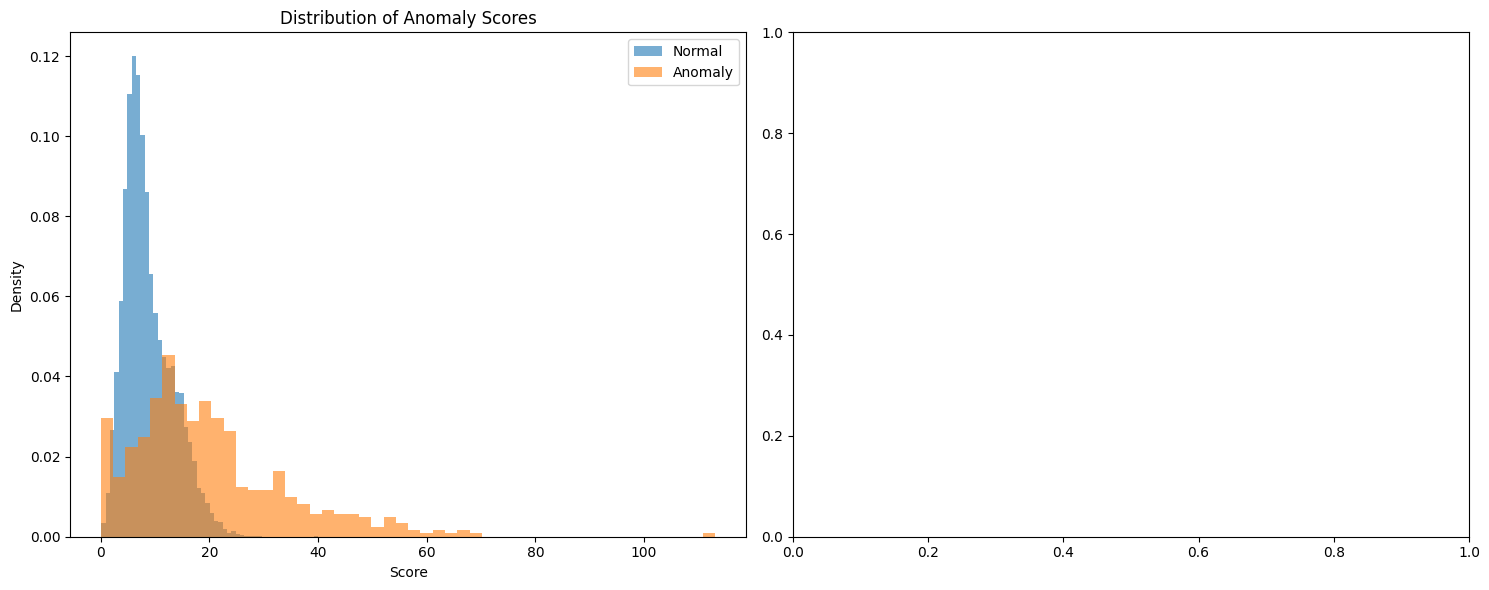

In [83]:
import matplotlib.pyplot as plt

# Data Prep
normal_scores  = anomaly_df[anomaly_df["is_anomaly"] == 0]["anomaly_score"]
anomaly_scores = anomaly_df[anomaly_df["is_anomaly"] == 1]["anomaly_score"]
#diff_normal    = anomaly_df[anomaly_df["is_anomaly"] == 0]["abs_duration_diff"]
#diff_anomaly   = anomaly_df[anomaly_df["is_anomaly"] == 1]["abs_duration_diff"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left Plot: Anomaly Scores
ax1.hist(normal_scores, bins=50, alpha=0.6, label="Normal", density=True)
ax1.hist(anomaly_scores, bins=50, alpha=0.6, label="Anomaly", density=True)
ax1.set_title("Distribution of Anomaly Scores")
ax1.set_xlabel("Score")
ax1.set_ylabel("Density")
ax1.legend()

# # Right Plot: Duration Diff (Split by Label)
# ax2.hist(diff_normal, bins=50, alpha=0.6, label="Normal", density=True)
# ax2.hist(diff_anomaly, bins=50, alpha=0.6, label="Anomaly", density=True)
# ax2.set_title("Distribution of Duration Shift")
# ax2.set_xlabel("abs_duration_diff (minutes)")
# ax2.legend()

plt.tight_layout()
plt.show()

In [84]:
# # Split normal and anomaly
# normal = merged[merged["is_anomaly"] == 0]
# anomaly = merged[merged["is_anomaly"] == 1]

# # Keep only 30% of normal (i.e., drop 70%)
# normal_downsampled = normal.sample(frac=0.01, random_state=42)

# # Recombine
# merged_new = pd.concat([normal_downsampled, anomaly], ignore_index=True)

# # Shuffle so labels are mixed
# merged_new = merged_new.sample(frac=1, random_state=42).reset_index(drop=True)
# merged = merged_new

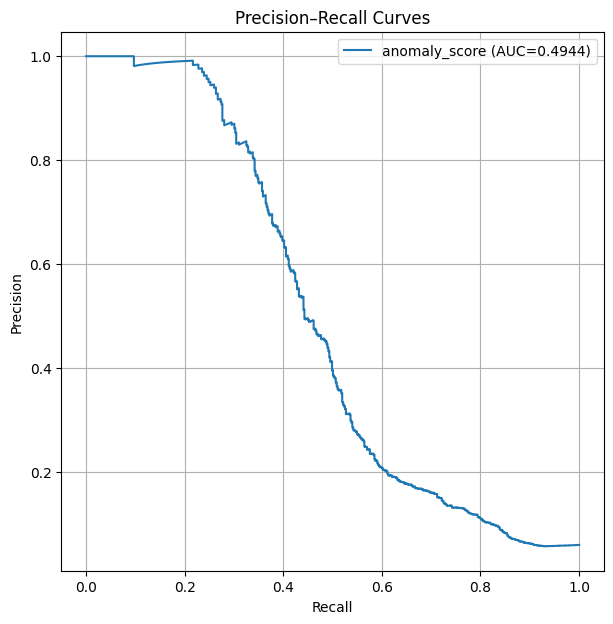

In [85]:
score_cols = [
    "anomaly_score"
]

y_true = anomaly_df["is_anomaly"].astype(int).values

plt.figure(figsize=(7, 7))

for col in score_cols:
    if col not in anomaly_df.columns:
        print(f"Skipping {col} (not found)")
        continue

    # drop rows where this score is NaN
    mask = ~anomaly_df[col].isna()
    if mask.sum() == 0:
        print(f"Skipping {col} (all NaN)")
        continue

    precision, recall, thresholds = precision_recall_curve(
        y_true[mask.values],
        anomaly_df.loc[mask, col].values
    )

    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{col} (AUC={pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()